# Stochastic Dynamics, AR(1) Processes, and Ergodicity

Undergraduate Computational Macro

Jesse Perla (University of British Columbia)

# Overview

## Motivation and Materials

-   In this lecture, we will introduce our stochastic processes and
    review probability
-   Our first example of a stochastic process is the **AR(1)** process
    (i.e. auto-regressive of order one)
    -   This is a simple, univariate process, but it is directly useful
        in many cases
-   We will also introduce the concept of **ergodicity** to help us
    understand long-run behavior
-   While this section is not directly introducing new economic models,
    it provides the backbone for our analysis of the wealth and income
    distribution

## Deterministic Processes

-   We have seen deterministic processes in previous lectures, e.g. the
    linear

    $$
    X_{t+1} = a X_t + b
    $$

    -   These are coupled with an initial condition $X_0$, which enables
        us to see the evolution of a variable
    -   The state variable, $X_t$, could be a vector
    -   The evolution could be non-linear $X_{t+1} = h(X_t)$, etc.

-   But many states in the real world involve randomness

## Materials

-   Adapted from QuantEcon lectures coauthored with John Stachurski and
    Thomas J. Sargent
    -   [AR1
        Processes](https://julia.quantecon.org/introduction_dynamics/ar1_processes.html)
    -   [LLN and
        CLT](https://julia.quantecon.org/tools_and_techniques/lln_clt.html)
    -   [Continuous State Markov
        Chains](https://julia.quantecon.org/tools_and_techniques/stationary_densities.html)

In [2]:
using LaTeXStrings, LinearAlgebra, Plots, Statistics
using Random, StatsPlots, Distributions, NLsolve
using Plots.PlotMeasures
default(;legendfontsize=16, linewidth=2, tickfontsize=12,
         bottom_margin=15mm)

# Random Variables Review

## Random Variables

-   **Random variables** are a collection of values with associated
    probabilities
-   For example, a random variable $Y$ could be the outcome of a coin
    flip
    -   Let $Y=1$ if heads and $Y=0$ if tails
    -   Assign probabilities $\mathbb{P}(Y=1) = \mathbb{P}(Y=0) = 0.5$
-   or a **normal random variable** with mean $\mu$ and variance
    $\sigma^2$, denoted $Y \sim \mathcal{N}(\mu, \sigma^2)$ has density
    $p(y) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y-\mu)^2}{2 \sigma^2} \right)$

## Discrete vs. Continuous Variables

-   If discrete (e.g., $X \in \{x_1, \ldots, x_N\}$) , then
    -   The **probability mass function** (pmf) is the probability of
        each value $p \in \mathbb{R}^N$
    -   Such that $\sum_{i=1}^N p_i = 1$, and $p_i \geq 0$
    -   i.e. $p_i = \mathbb{P}(X=x_i)$
-   If continuous, then the **probability density function** (pdf) is
    the probability of each value and can be represented by a function
    -   $p : \mathbb{R} \rightarrow \mathbb{R}$ if $X$ is defined on
        $\mathbb{R}$
    -   $\int_{-\infty}^\infty p(x) dx = 1$, and $p(x) \geq 0$
    -   $\mathbb{P}(X = a) = 0$ in our examples, and
        $\mathbb{P}(X \in [a,b]) = \int_a^b p(x) dx$

## Normal Random Variables


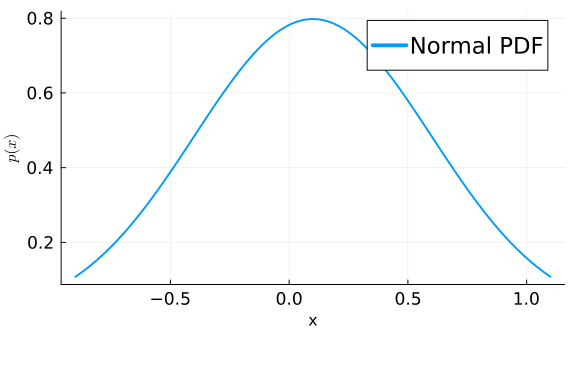

In [3]:
mu = 0.1
sigma = 0.5
d = Normal(0.1, sigma) # SD not variance
x = range(mu - 2 * sigma,
          mu + 2 * sigma;
          length=100)
plot(x, pdf.(d, x); label="Normal PDF",
     xlabel="x", ylabel=L"p(x)",
     size=(600,400))

## Comparing to a Histogram


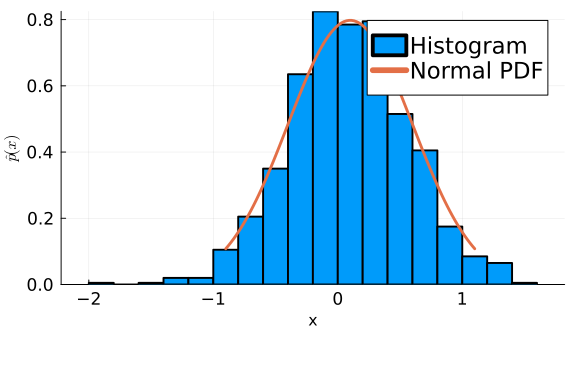

In [4]:
n = 1000
x_draws = rand(d, n) # gets n samples
histogram(x_draws; label="Histogram",
          xlabel="x", ylabel=L"\hat{p}(x)",
          normalize=true, size=(600,400))
plot!(x, pdf.(d, x); label="Normal PDF",
      lw=3)          

## Normal Random Variables

-   Normal random variables are special for many reasons (e.g., central
    limit theorems)
-   They are the only continuous random variable with finite variance
    that is closed under linear combinations
    -   For independent $X \sim \mathcal{N}(\mu_X, \sigma_X^2)$ and
        $Y \sim \mathcal{N}(\mu_Y, \sigma_Y^2)$
    -   $a X + b Y \sim \mathcal{N}(a \mu_X + b \mu_Y, a^2 \sigma_X^2 + b^2 \sigma_Y^2)$
    -   Also true with multivariate normal distributions
-   Common transformation taking out mean and variance
    -   Could draw $Y \sim N(\mu, \sigma^2)$
    -   Or could draw $X \sim N(0,1)$ and then $Y = \mu + \sigma X$

## Expectations

-   For discrete-valued random variables

    $$
    \mathbb{E}[f(X)] = \sum_{i=1}^N f(x_i) p_i
    $$

-   For continuous valued random variables $$
    \mathbb{E}[f(X)] = \int_{-\infty}^\infty f(x) p(x) dx
    $$

## Moments

-   The **mean** of a random variable is the first moment,
    $\mathbb{E}[X]$
-   The **variance** of a random variable is the second moment,
    $\mathbb{E}[(X-\mathbb{E}[X])^2]$
    -   Note the recentering by the mean. Could also calculate as
        $\mathbb{E}[X^2] - \mathbb{E}[X]^2$
-   Normal random variables are characterized by their first 2 moments

## Law(s) of Large Numbers

-   Let $X_1, X_2, \ldots$ be independent and identically distributed
    (iid) random variables with mean
    $\mu \equiv \mathbb{E}(X) < \infty$, then let $$
    \bar{X}_n \equiv \frac{1}{n} \sum_{i=1}^n X_i
    $$

-   One version is **Kolmogorov’s Strong Law of Large Numbers** $$
    \mathbb{P} \left( \lim_{n \rightarrow \infty} \bar{X}_n = \mu \right) = 1
    $$

    -   i.e. the average of the random variables converges to the mean

## Sampling and Plotting the Mean

In [5]:
function ksl(distribution, n = 100)
    title = nameof(typeof(distribution))
    observations = rand(distribution, n)
    sample_means = cumsum(observations) ./ (1:n)
    mu = mean(distribution)
    plot(repeat((1:n)', 2), [zeros(1, n); observations']; title,  xlabel="n",
         label = "", color = :grey, alpha = 0.5)
    plot!(1:n, observations; color = :grey, markershape = :circle,
          alpha = 0.5, label = "", linewidth = 0)
    if !isnan(mu)
        hline!([mu], color = :black, linewidth = 1.5, linestyle = :dash,
               grid = false, label = L"\mathbb{E}[X]")
    end
    return plot!(1:n, sample_means, linewidth = 3, alpha = 0.6, color = :green, label = L"\bar{X}_n")
end

ksl (generic function with 2 methods)

## LLN with the Normal Distribution


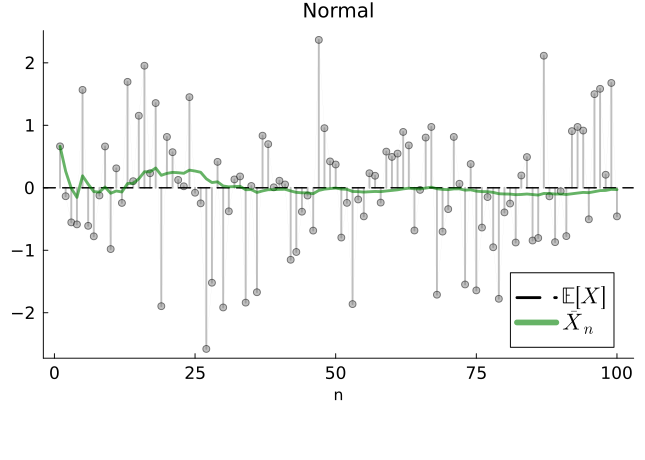

In [6]:
dist = Normal(0.0, 1.0) # unit normal
ksl(dist)

## LLN with the Exponential

-   $f(x) = \frac{1}{\alpha} \exp(-x/\alpha)$ for $x \geq 0$ with mean
    $\alpha$


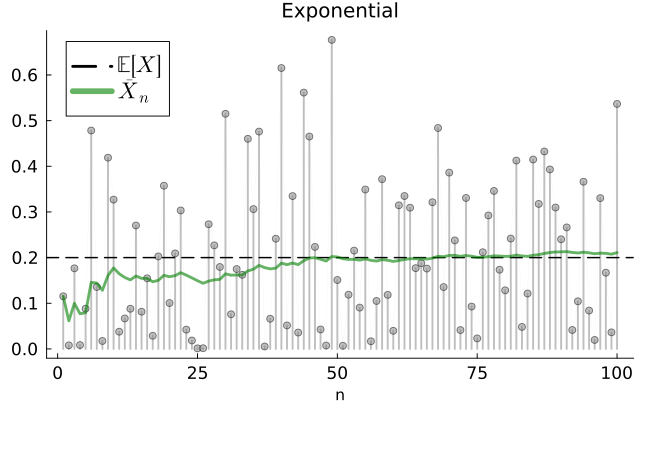

In [7]:
dist = Exponential(0.2)
ksl(dist)

## LLN with the Cauchy?

-   $f(x) = 1/(\pi (1+x^2))$, with median $= 0$ and $\mathbb{E}(X)$
    undefined


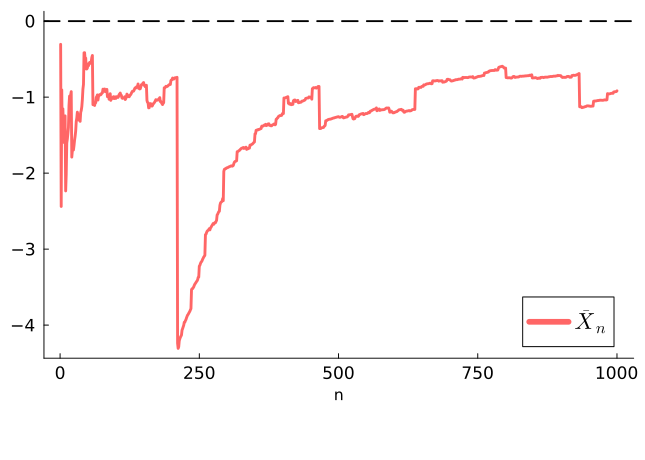

In [8]:
Random.seed!(0); # reproducible results
dist = Cauchy() # Doesn't have an expectation!
sample_mean = cumsum(rand(dist, n)) ./ (1:n)
plot(1:n, sample_mean, color = :red, alpha = 0.6, label =  L"\bar{X}_n",
      xlabel = "n", linewidth = 3)
hline!([0], color = :black, linestyle = :dash, label = "", grid = false)

## Monte-Carlo Calculation of Expectations

-   One application of this is the numerical calculation of expectations

-   Let $X$ be a random variable with density $p(x)$, and hence
    $\mathbb{E}[f(X)] = \int_{-\infty}^\infty f(x) p(x) dx$ (or
    $\sum_{i=1}^N f(x_i) p_i$ if discrete)

-   These integrals are often difficult to calculate analytically, but
    if we can draw $X \sim p$, then we can approximate the expectation
    by

    $$
    \mathbb{E}[f(X)] \approx \frac{1}{n} \sum_{i=1}^n f(x_i)
    $$

-   Then by the LLN this converges to the true expectation as
    $n \rightarrow \infty$

## Discrete Example

-   Let $X$ be a discrete random variable with $N$ states and
    probabilities $p_i$
-   Then $\mathbb{E}[f(X)] = \sum_{i=1}^N f(x_i) p_i$
-   For example, the Binomial distribution and $f(x) = \log(x+1)$

In [9]:
# number of trials and probability of success
dist = Binomial(10, 0.5)
plot(dist;label="Binomial PMF",
     size=(600,400))
vals = support(dist) # i.e. 0:10
p = pdf.(dist, vals)
# Calulate the expectation manually
@show mean(dist), dot(vals, p);

(mean(dist), dot(vals, p)) = (5.0, 5.000000000000008)

## Using Monte-Carlo

(f_expec, f_expec_mc) = (1.7526393207741702, 1.7552834928857293)


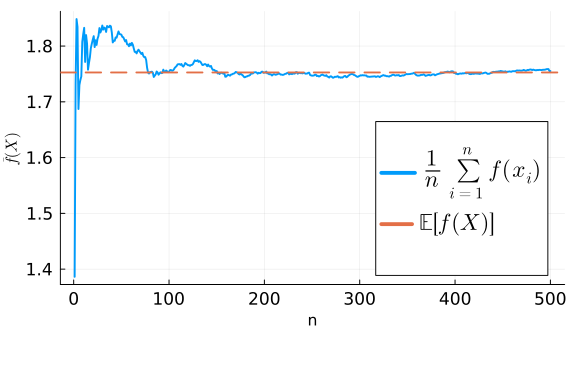

In [10]:
N = 500
# expectation with PMF, then MC
f_expec = dot(log.(vals .+ 1), p)
x_draws = rand(dist, N)
f_x_draws = log.(x_draws .+ 1)
f_expec_mc = sum(f_x_draws) / N
@show f_expec, f_expec_mc
# Just calculate sums then divide by N
f_means = cumsum(f_x_draws)./(1:N)
plot(1:length(f_means), f_means;
     label=L"\frac{1}{n}\sum_{i=1}^n f(x_i)",
     xlabel="n", ylabel=L"\bar{f}(X)",
     size=(600,400))
hline!([f_expec];linestyle = :dash,
       label = L"\mathbb{E}[f(X)]")

# Stochastic Processes

## Stochastic Processes

-   A **stochastic process** is a sequence of random variables
    -   We will focus on **discrete time** stochastic processes, where
        the sequence is indexed by $t=0,1,2,\ldots$
    -   Could be discrete or continuous random variables
-   Skipping through some formality, assume that they share the same
    values but probabilities may change
-   Denote then as a sequence $\{X_t\}_{t=0}^\infty$

## Joint, Marginal, and Conditional Distributions

-   Can ask questions on the probability distributions of the process
-   The **joint distribution** of $\{X_t\}_{t=0}^{\infty}$ or a subset
    -   In many cases things will be correlated over time or else no
        need to be a process
-   The **marginal distribution** of $X_t$ for any $t$
    -   This is a proper PDF, marginalized from the joint distribution
        of all values
-   **Conditional distributions**, fixing some values
    -   e.g. $X_{t+1}$ given $X_t, X_{t-1}$, etc. are known

## Markov Process

-   Before we go further, lets discuss a broader class of these
    processes useful in economics
-   A **Markov process** is a stochastic process where the conditional
    distribution of $X_{t+1}$ given $X_t, X_{t-1}, \ldots$ is the same
    as the conditional distribution of $X_{t+1}$ given $X_t$
    -   i.e. the future is independent of the past given the present
-   Note that with the AR(1) model, if I know $X_t$ then I can calculate
    the PDF of $X_{t+1}$ directly without knowing the past
-   This is “first-order” since only one lag is required, but could be
    higher order
    -   A finite number of lags can always be added to the state vector
        to make it first-order

# AR(1) Processes

## A Simple Auto-Regressive Process with One Lag

$$
X_{t+1} = a X_t + b + c W_{t+1}
$$

-   Just added randomness to the deterministic process from time $t$ to
    $t+1$
-   $W_{t+1} \sim \mathcal{N}(0, 1)$ is IID “shocks” or “noise”
-   Could have an initial condition for $X_0$ Or could have an initial
    distribution
    -   $X_t$ is a random variable, and so can $X_0$
    -   “Degenerate random variable” if $P(X_0 = x) = 1$ for some $x$
    -   Assume $X_0 \sim \mathcal{N}(\mu_0, v_0)$, and $v_0 \to 0$ is
        the degenerate case

## Evolution of the AR(1) Process

-   Both $W_{t+1}$ and $X_0$ are assumed to be normally distributed
-   As we discussed, linear combinations of normal random variables are
    normal
    -   So $X_t$ is normal for all $t$ by induction
-   Furthermore, we have a formula for the recursion
    -   If $X_t \sim \mathcal{N}(\mu_t, v_t)$, then
        $X_{t+1} \sim \mathcal{N}(a \mu_t + b, a^2 v_t + c^2)$
    -   Hence, the evolution of the mean and variance follow a simple
        difference equation $\mu_{t+1} = a \mu_t + b$ and
        $v_{t+1} = a^2 v_t + c^2$
    -   Let $X_t \sim \psi_t \equiv \mathcal{N}(\mu_t, v_t)$

## Visualizing the AR(1) Process

In [11]:
a = 0.9
b = 0.1
c = 0.5

# initial conditions mu_0, v_0
mu = -3.0
v = 0.6

0.6

## Visualizing the AR(1) Process


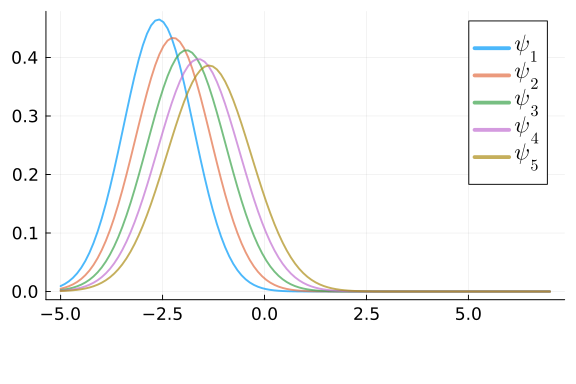

In [12]:
sim_length = 5
x_grid = range(-5, 7, length = 120)

plt = plot(;size = (600, 400))
for t in 1:sim_length
    mu = a * mu + b
    v = a^2 * v + c^2
    dist = Normal(mu, sqrt(v))
    plot!(plt, x_grid, pdf.(dist, x_grid),
    label = L"\psi_{%$t}", linealpha = 0.7)
end
plt

## From a Degenerate Initial condition

-   Cannot plot $\psi_0$ since it is a point mass at $\mu_0$


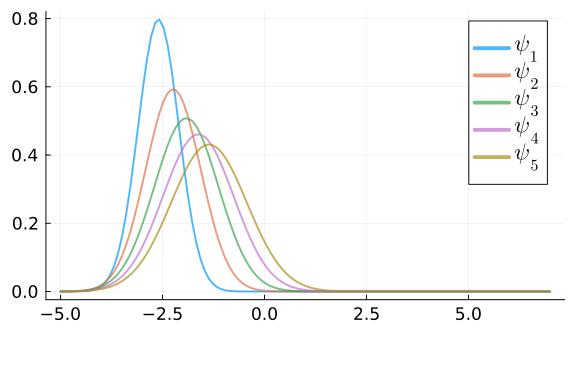

In [13]:
mu = -3.0
v = 0.0
plt = plot(;size = (600, 400))
for t in 1:sim_length
    mu = a * mu + b
    v = a^2 * v + c^2
    dist = Normal(mu, sqrt(v))
    plot!(plt, x_grid, pdf.(dist, x_grid),
    label = L"\psi_{%$t}", linealpha = 0.7)
end
plt

## Practice with Iteration

-   Let us practice creating a map and iterating it
-   We will need to modify our `iterate_map` function to work with
    vectors
-   Let $x \equiv \begin{bmatrix}\mu & v\end{bmatrix}^{\top}$,

In [14]:
function iterate_map(f, x0, T)
    x = zeros(length(x0), T + 1)
    x[:, 1] = x0
    for t in 2:(T + 1)
        x[:, t] = f(x[:, t - 1])
    end
    return x
end

iterate_map (generic function with 1 method)

## Implementation of the Recurrence for the AR(1)

In [15]:
function f(x;a, b, c)
  mu = x[1]
  v = x[2]
  return [a * mu + b, a^2 * v + c^2]
end
x_0 = [-3.0, 0.6]
T = 5
x = iterate_map(x -> f(x; a, b, c), x_0, T)

2×6 Matrix{Float64}:
 -3.0  -2.6    -2.24     -1.916    -1.6244   -1.36196
  0.6   0.736   0.84616   0.93539   1.00767   1.06621

## Using Matrices

$$
x_{t+1} = \underbrace{\begin{bmatrix} a & 0 \\ 0 & a^2 \end{bmatrix}}_{\equiv A} x_t + \underbrace{\begin{bmatrix} b \\ c^2 \end{bmatrix}}_{\equiv B}
$$

In [16]:
A = [a 0; 0 a^2]
B = [b; c^2]
x = iterate_map(x -> A * x + B, x_0, T)

2×6 Matrix{Float64}:
 -3.0  -2.6    -2.24     -1.916    -1.6244   -1.36196
  0.6   0.736   0.84616   0.93539   1.00767   1.06621

## Fixed Point?

-   Whenever you have maps, you can ask whether a fixed point exists
-   This is especially easy to check here. Solve,
    -   $\mu = a \mu + b \implies \mu = \frac{b}{1-a}$
    -   $v = a^2 v + c^2 \implies v = \frac{c^2}{1-a^2}$
-   Lets check for a fixed point numerically

In [17]:
sol = fixedpoint(x -> A * x + B, x_0)
@show sol.zero
@show b/(1-a), c^2/(1-a^2);

sol.zero = [1.0000000000000266, 1.3157894736842035]
(b / (1 - a), c ^ 2 / (1 - a ^ 2)) = (1.0000000000000002, 1.3157894736842108)

## Existence of a Fixed Point

-   The important of $a$ is also clear when we look at the $A$ matrix
-   We know the eigenvalues of a diagonal matrix are the diagonal
    elements
    -   i.e., $\lambda_1 = a$ and $\lambda_2 = a^2$
-   If $|a| < 1$, then $a^2 < |a| < 1$ and hence the maxim absolute
    value of the eigenvalues below 1
-   As we saw in the univariate case, conditions of this sort were
    crucial to determine whether the systems would converge
-   We will see more complicated versions of the $A$ matrix as we move
    into richer “state space models”

## Evolution of the Probability Distributions


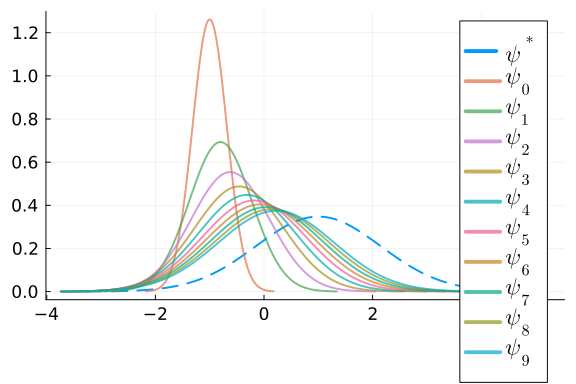

In [18]:
x_0 = [-1.0, 0.1] # tight
T = 10
f(x) =  A * x + B
x = iterate_map(f, x_0, T)
x_star = fixedpoint(f, x_0).zero
plt = plot(Normal(x_star[1], sqrt(x_star[2]));
           label = L"\psi^*",
           style = :dash,
           size = (600, 400))
for t in 1:T
    dist = Normal(x[1, t], sqrt(x[2, t]))
    plot!(plt, dist, label = L"\psi_{%$(t-1)}",
         linealpha = 0.7)
end
plt

# Stationary Distributions

## Fixed Points and Steady States

-   Recall in the lecture on deterministic dynamics that we discussed
    fixed point and steady states $x_{t+1} = f(x_t)$ has a **fixed
    point** $x^*$ if $x^* = f(x^*)$
    -   e.g. $x_{t+1} = a x_t + b$ has $x^* = \frac{b}{1-a}$ if
        $|a| < 1$
-   We can also interpret as a **steady state** $x^*$ as
    $\lim_{t \rightarrow \infty} x_t = x^*$ for some $x_0$
    -   Stability looked at stability which told us about which $x^*$
        the process would approach from points $x_0$ near $x^*$
-   The key: for $x^*$ if we apply $f(x^*)$ evolution equation and
    remain at that point

## Stationary Distributions

-   Analogously, with stochastic processes we can think about applying
    the evolution equation to random variables
    -   Instead of a point, we have a distribution $\psi^*$
    -   Then rather than checking $x^* = f(x^*)$, we check
        $\psi^* \sim f(\psi^*)$, where that notation is loosely taking
        into account the distribution of shocks
-   Similar to stability, we can consider if repeatedly applying
    $f(\cdot)$ repeatedly to various $\psi_0$ converges to $\psi^*$

## AR(1) Example

-   Take $X_{t+1} = a X_t + b + c W_{t+1}$ if $|a| < 1$ for
    $W_{t+1} \sim \mathcal{N}(0, 1)$

-   Recall If $X_t \sim \mathcal{N}(\mu_t, v_t) \equiv \psi_t$, then
    using properties of Normals

    -   $X_{t+1} \sim \mathcal{N}(a \mu_t + b, a^2 v_t + c^2)\equiv \psi_{t+1}$
    -   We derived the fixed point of the mean and variance iteration as
        $\psi^* \sim \mathcal{N}\left(\mu^*, v^*\right) = \mathcal{N}\left(\frac{b}{1-a}, \frac{c^2}{1-a^2}\right)$

-   Apply the evolution equation to $\psi^*$ we demonstrate that
    $\psi^* \sim f(\psi^*)$

    $$
    \mathcal{N}\left(a \frac{b}{1-a} + b, a^2 \frac{c^2}{1-a^2} + c^2\right) = \mathcal{N}\left(\frac{b}{1-a}, \frac{c^2}{1-a^2}\right)
    $$

    -   i.e., from any initial condition, the distribution of $X_t$
        converges to $\psi^*$

## What if $a > 1$?


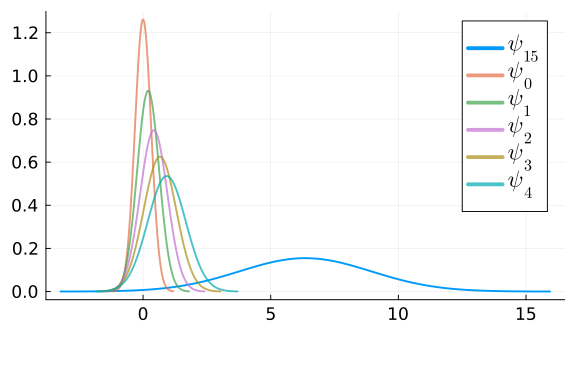

In [19]:
a,b,c = 1.1, 0.2, 0.25
A = [a 0; 0 a^2]
B = [b; c^2]
f(x) =  A * x + B
T = 15
x = iterate_map(f, [0.0, 0.1], T)
plt = plot(Normal(x[1, end], sqrt(x[2, end]));
            label = L"\psi_{%$T}",
           size = (600, 400))
for t in 1:5
    dist = Normal(x[1, t], sqrt(x[2, t]))
    plot!(plt, dist, label=L"\psi_{%$(t-1)}",
         linealpha = 0.7)
end
plt

## Analyzing the Failure of Convergence

-   If it exists, the stationary distribution would need to be
    $\psi^* \equiv \mathcal{N}\left(\frac{b}{1-a}, \frac{c^2}{1-a^2}\right)$
-   Note that if $b > 0$ we get the drift of the process forward
    -   But, just as in the case of the deterministic process, this just
        acts as a force to move the distribution, not spread it out
-   In fact, with $b=0$ the mean of $\psi_t$ is always 0, but the
    variance grows without bound if $c > 0$
-   Lets plot the $a=1,b=0$ case

## What if $a = 1, b=0$?


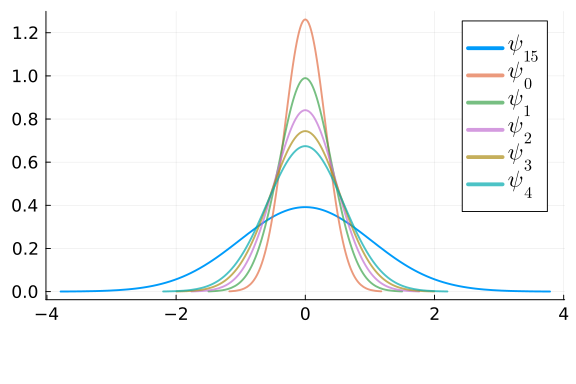

In [20]:
a,b,c = 1.0, 0.0, 0.25
A = [a 0; 0 a^2]
B = [b; c^2]
f(x) =  A * x + B
T = 15
x = iterate_map(f, [0.0, 0.1], T)
plt = plot(Normal(x[1, end], sqrt(x[2, end]));
            label = L"\psi_{%$T}",
           size = (600, 400))
for t in 1:5
    dist = Normal(x[1, t], sqrt(x[2, t]))
    plot!(plt, dist, label=L"\psi_{%$(t-1)}",
         linealpha = 0.7)
end
plt

## Ergodicity

-   There are many different variations and definitions of ergodicity
-   Among other things, this rules out are cases where the process is
    “trapped” in a subset of the state space and can’t swith out
-   Also ensures that the distribution doesn’t spread or drift
    asymptotically
-   Ergodicity lets us apply LLNs to the stochastic process, even though
    they are not independent

## Ergodicity

-   We will consider a process $\{X_t\}_{t=0}^\infty$ with a stationary
    distribution $\psi^*$
-   The process is **ergodic** if for any
    $f : \mathbb{R} \rightarrow \mathbb{R}$ (with regularity conditions)
    $$
    \lim_{T\to\infty}\frac{1}{T} \sum_{t=1}^T f(X_t) = \int f(x)\psi^*(x) dx
    $$
    -   i.e. the time average of the function converges to the
        expectation of the function. Mean ergodic if only require this
        to work for $f(x) = x$

## Iteration with IID Noise

-   Adapt scalar iteration for iid noise

In [21]:
function iterate_map_iid(f, dist, x0, T)
    x = zeros(T + 1)
    x[1] = x0
    for t in 2:(T + 1)
        x[t] = f(x[t - 1], rand(dist))
    end
    return x
end
a,b,c = 0.9, 0.1, 0.05
x_0 = 0.5
T = 5
h(x, W) = a * x + b + c * W # iterate given random shock
x = iterate_map_iid(h, Normal(), x_0, T)

6-element Vector{Float64}:
 0.5
 0.5252717486805177
 0.5306225876900339
 0.46819901566492783
 0.532032538532688
 0.583020976850554

## Demonstration of Ergodicity with Mean


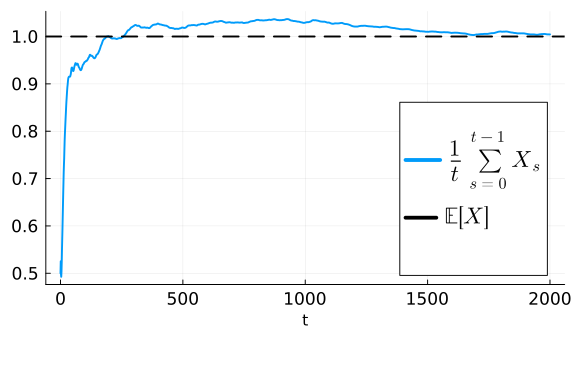

In [22]:
T = 2000
x_0 = 0.5
x = iterate_map_iid(h, Normal(), x_0, T)
x_means = cumsum(x)./(1:(T+1))
plot(0:T, x_means;
  label=L"\frac{1}{t}\sum_{s=0}^{t-1} X_s",
  xlabel = "t", size = (600, 400))
hline!([b/(1-a)], color = :black,
  linestyle = :dash,
  label = L"\mathbb{E}[X]")

## Starting at the Stationary Distribution

-   A reasonable place to start many simulations is a draw from the
    stationary distribution


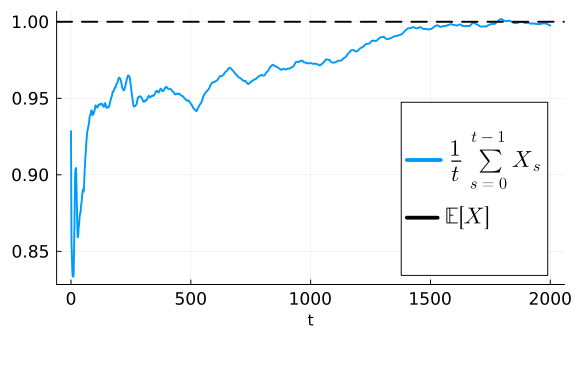

In [23]:
Random.seed!(20)
x_0 = rand(Normal(b/(1-a), sqrt(c^2/(1-a^2))))
x = iterate_map_iid(h, Normal(), x_0, T)
x_means = cumsum(x)./(1:(T+1))
plot(0:T, x_means;
  label=L"\frac{1}{t}\sum_{s=0}^{t-1} X_s",
  xlabel = "t", size = (600, 400))
hline!([b/(1-a)], color = :black,
  linestyle = :dash,
  label = L"\mathbb{E}[X]")

## The Speed of Convergence

-   The speed with which the process converges towards its stationary
    distribution is important
-   Key things which govern this transition will be
    -   Autocorrelation: As $a$ goes closer to $0$, the faster it
        converges back towards the mean - as with deterministic
        processes
    -   Variances: Wth large $c$ the noise may dominate and the $\psi^*$
        becomes broader

## Close to a Random Walk


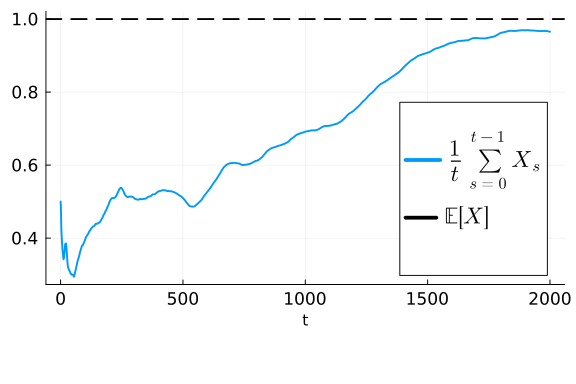

In [24]:
Random.seed!(20)
a,b,c = 0.99, 0.01, 0.05
h(x, W) = a * x + b + c * W
T = 2000
x_0 = 0.5
x = iterate_map_iid(h, Normal(), x_0, T)
x_means = cumsum(x)./(1:(T+1))
plot(0:T, x_means;
  label=L"\frac{1}{t}\sum_{s=0}^{t-1} X_s",
  xlabel = "t", size = (600, 400))
hline!([b/(1-a)], color = :black,
  linestyle = :dash,
  label = L"\mathbb{E}[X]")

## Dependence on Initial Condition

-   Intuition: ergodicity is that the initial conditions “wear off” over
    time
-   However, even if a process is ergodic and has a well-defined
    stationary distribution, it may take a long time to converge to it
-   This is very important in many quantitative models:
    -   How much does your initial wealth matter for your long-run?
    -   If your wages start low due to discrimination, migration, or
        just bad luck, how long does it converge?
    -   If we provide subsidies to new firms, how long would it take for
        that to affect the distribution of firms?

## Example of a Non-Ergodic Stochastic Process

-   Between $t=0$ and $t=1$ a coin is flipped (e.g., result of key exam)
    -   If heads: income follows $X_{t+1} = a X_t + b + c W_{t+1}$ with
        $b=0.1$ for $t \geq 1$
    -   If tails: income follows $X_{t+1} = a X_t + b + c W_{t+1}$ with
        $b=1.0$ for $t \geq 1$
-   The initial condition and early sequence cannot be forgotten
-   If there is ANY probability of switching between careers, then it is
    ergodic because it “mixes”

## Moving Average Representation, MA($\infty$), for AR(1)

-   From $X_t = a X_{t-1} + b + c W_t$, iterate backwards to $X_0$ and
    $W_1$ $$
    \begin{aligned}
    X_t &= a \left(a X_{t-2} + b + c W_{t-1}\right) + b + c W_t \\
    &= a^2 X_{t-2} + b (1 + a) + c (W_t + a W_{t-1})\\
    &= a^2 \left(a X_{t-3} + b + c W_{t-2}\right)+ b (1 + a) + c (W_t + a W_{t-1})\\
    &= a^t X_0 + b \sum_{j=0}^{t-1} a^j + c \sum_{j=0}^{t-1} a^j W_{t-j}\\
    &= a^t X_0 + b \frac{1-a^t}{1-a} + c \sum_{j=0}^{t-1} a^j W_{t-j}
    \end{aligned}
    $$

## Interpreting the Auto-Regressive Parameter

-   The distribution of $X_t$ then depends on the distribution of $X_0$
    and the distribution of the sum of $t-1$ iid random variables

-   If $X_0$ and $W_t$ are normal, then $X_t$ is normal since it is a
    linear combination $$
    X_t = a^t X_0 + b \frac{1-a^t}{1-a} + c \sum_{j=0}^{t-1} a^j W_{t-j}
    $$

    -   If $a = 1$ then the initial condition is never “forgotten”
    -   If $a = 1$, $W_{t-j}$ shocks are just as important determining
        the distribution of $X_t$ because the $a^j$ doesn’t “decay” over
        time

## Simulation of Moving Average Representation


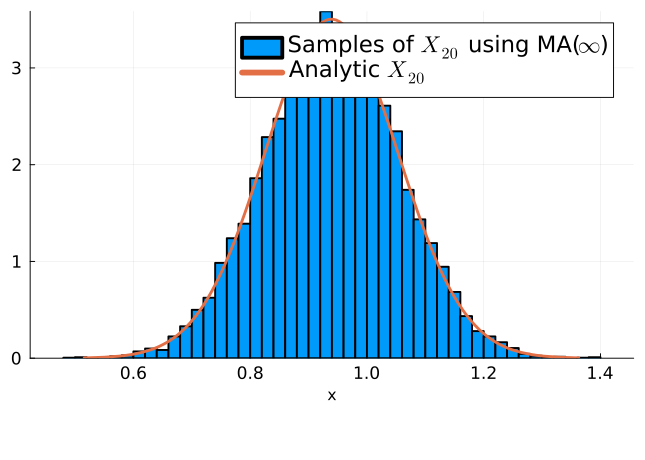

In [25]:
X_0 = 0.5 # degenerate prior
a, b, c = 0.9, 0.1, 0.05
A = [a 0; 0 a^2]
B = [b; c^2]
T = 20
num_samples = 10000
Xs = iterate_map(x -> A * x + B, [X_0, 0], T)
X_T = Normal(Xs[1, end], sqrt(Xs[2, end]))
W = randn(num_samples, T)
# Comprehensions and generators example, looks like math
X_T_samples = [a^T * X_0 + b * (1-a^T)/(1-a) + c * sum(a^j * W[i, T-j] for j in 0:T-1)
               for i in 1:num_samples]
histogram(X_T_samples; xlabel="x", normalize=true,
          label=L"Samples of $X_{%$T}$ using MA($\infty$)")
plot!(X_T; label=L"Analytic $X_{%$T}$", lw=3)      

# Nonlinear Stochastic Processes

## Nonlinearity with Additive Shocks

-   A useful class involves nonlinear functions for the drift and
    variance

    $$
    X_{t+1} = \mu(X_t) + \sigma(X_t) W_{t+1}
    $$

    -   IID $W_{t+1}$ with $\mathbb{E}[W_{t+1}] = 0$ and frequently
        $\mathbb{E}[W_{t+1}^2] = 1$

-   Nests our AR(1) process

    -   $\mu(x) = a x + b$ and $\sigma(x) = c$

## Auto-Regressive Conditional Heteroskedasticity (ARCH)

-   For example, we may find that time-series data has time-varying
    volatility and depends on 1 lags $$
    X_{t+1} = a X_t + \sigma_t W_{t+1}
    $$

    -   And that the variance increases as we move away from the mean of
        the stationary distribution $\sigma_t^2 = \beta + \gamma X_t^2$

-   Hence the process becomes an ARCH(1)

    $$
    X_{t+1} = a X_t + \left(\beta + \gamma X_t^2\right)^{1/2} W_{t+1}
    $$

## Simulation of ARCH(1)


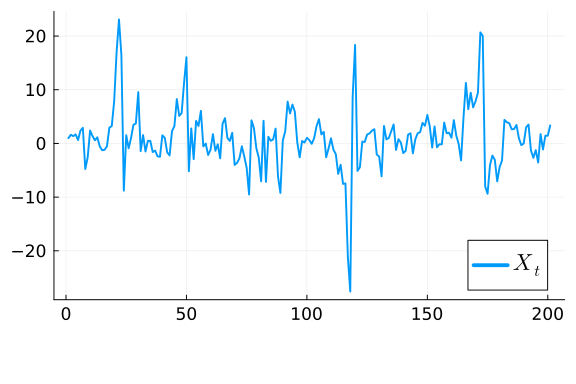

In [26]:
a = 0.7
beta, gamma = 5, 0.5
X_0 = 1.0
T = 200
h(x, W) = a * x + sqrt(beta + gamma * x^2) * W
x = iterate_map_iid(h, Normal(), X_0, T)
plot(x; label = L"X_t", size = (600, 400))

## AR(1) with a Barrier

-   Nonlinearity in economics often comes in various forms of barriers,
    e.g. borrowing constraints

-   Consider our AR(1) except that the process can never go below $0$

    $$
    X_{t+1} = \max\{a X_t + b + c W_{t+1}, 0.0\}
    $$

-   We could **stop** the process at this point, but instead we will
    continue to iterate

## Simulation of AR(1) with a Barrier


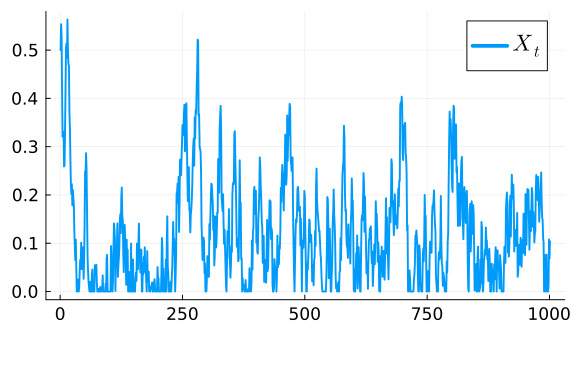

In [27]:
a,b,c = 0.95, 0.00, 0.05
X_min = 0.0
h(x, W) = max(a * x + b + c * W, X_min)
T = 1000
x_0 = 0.5
x = iterate_map_iid(h, Normal(), x_0, T)
plot(x; label = L"X_t", size = (600, 400))

## Histogram of the AR(1) with a Barrier

-   There isn’t a true density of $\psi^*$ due to the point mass at $0$


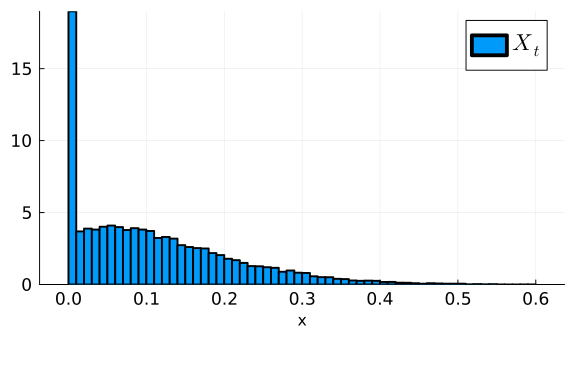

In [28]:
T = 20000
x = iterate_map_iid(h, Normal(), x_0, T)
histogram(x; label = L"X_t", normalize = true,
          xlabel = "x", size = (600, 400))

# Stochastic Growth Model

## Simple Growth Model with Stochastic Productivity

-   Turning off population growth, for $f(k) = k^\alpha$, and
    $s, \delta$ constants $$
    k_{t+1} = (1-\delta) k_t + s Z_t f(k_t),\quad \text{given } k_0
    $$

-   Let log productivity, $z_t\equiv \log Z_t$, follow an AR(1) process
    (why logs?)

    $$
    \log Z_{t+1} = a \log Z_t + b + c W_{t+1}
    $$

## Stationary Distribution of Productivity

-   Recall that the stationary distribution of $\log Z_t$ is
    $\mathcal{N}\left(\frac{b}{1-a}, \frac{c^2}{1-a^2}\right)$
-   Given the stationary distribution of $Z_t$ is lognormal, we can
    check ergodicity


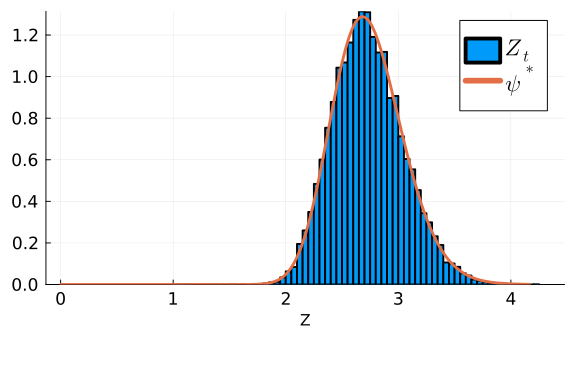

In [29]:
a, b, c = 0.9, 0.1, 0.05
Z_0 = 1.0
T = 20000
h(z, W) = a * z + b + c * W
z = iterate_map_iid(h, Normal(), log(Z_0), T)
Z = exp.(z)
histogram(Z; label = L"Z_t", normalize = true,
          xlabel = "Z", size = (600, 400))
plot!(LogNormal(b/(1-a), sqrt(c^2/(1-a^2))),
      lw = 3, label = L"\psi^*")

## Quantiles

-   Reminder: A quantile $q$ is the $x$ such that
    $\mathbb{P}(X \leq x) = q$
-   Or, given a density $f(x)$ the quantile is the $x$ such that
    $\int_{-\infty}^x f(x) dx = q$
-   With data we can calculate an empirical quantile by first sorting
    the data, then finding the value of the observations below a certain
    count which is the proportion of the elements
    -   e.g. with 100 observations, the 5th percentile is the 5th
        smallest observation
-   The 0.5 quantile (i.e., the 50th percentile) is the median
-   For heavily skewed distributions, the median is often a better
    measure of central tendency than the mean

## Practice with Iteration and Multivariate Functions

In [30]:
function iterate_map_iid_vec(h, dist, x0, T)
    x = zeros(length(x0), T + 1)
    x[:, 1] = x0
    for t in 2:(T + 1)
        # accepts whatever type rand(dist) returns
        x[:, t] = h(x[:, t - 1], rand(dist))
    end
    return x
end

iterate_map_iid_vec (generic function with 1 method)

## Simulation of the Stochastic Growth Model


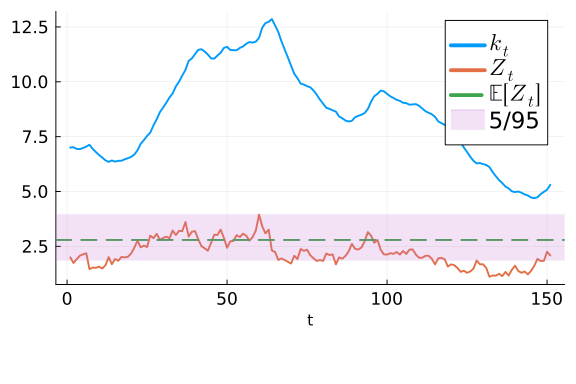

In [31]:
alpha, delta, s = 0.3, 0.1, 0.2
a, b, c = 0.9, 0.1, 0.1
function h(x, W)
    k = x[1]
    z = x[2]
    return [(1-delta) * k + s * exp(z) * k^alpha,
            a * z + b + c * W]
end
x_0 = [7.0, log(2.0)] # k_0, z_0
T = 150
x = iterate_map_iid_vec(h, Normal(), x_0, T)
plot(x[1, :]; label = L"k_t", xlabel = "t", size = (600, 400), legend=:topright)
plot!(exp.(x[2, :]), label = L"Z_t")
dist = LogNormal(b/(1-a), sqrt(c^2/(1-a^2)))
hline!([mean(dist)]; linestyle = :dash, label = L"\mathbb{E}[Z_t]")
hline!([quantile(dist, 0.05)]; lw=0, fillrange = [quantile(dist, 0.95)], fillalpha=0.2, label = "5/95")

## Ergodicity and Capital Accumulation

-   Evaluate the closed-form steady-state capital $k^*$ for the
    deterministic model


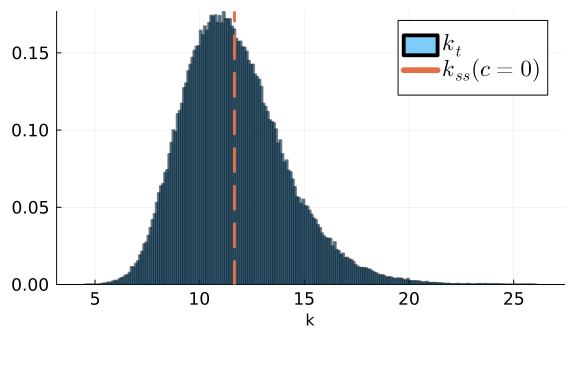

In [32]:
# Remember nonstochastic steady-state
k_ss_det=  (s*mean(dist)/delta)^(1/(1-alpha))

T = 200000
x = iterate_map_iid_vec(h, Normal(), x_0, T)
histogram(x[1, :]; label = L"k_t",
          normalize = true, xlabel = "k",
          alpha=0.5, size = (600, 400))
vline!([k_ss_det]; linestyle = :dash, lw=3,
       label = L"k_{ss}(c = 0)")

# Multiplicative Growth Processes

## Proportional Growth

-   Many values grow or shrink proportional to their current size
    -   e.g. population, firms, wealth, etc.
-   The growth rates are themselves often random
    -   e.g. population growth rates, firm growth rates, returns on
        wealth
    -   Random good or bad luck can compound, which changes the
        distribution
-   See [here](https://python.quantecon.org/kesten_processes.html#id15)
    for more

## Kesten Process

-   The simplest **Kesten Process** is a process of the form

    $$
    X_{t+1} = a_{t+1} X_t + y_{t+1}
    $$

    -   $X_t$ is a state variable
    -   $a_{t+1}$ is an IID random growth rate
    -   $y_{t+1}$ is an IID random shock

-   Examples: if population is $N_t$ and growth rate between $t$ and
    $t+1$ is $g_{t+1}$

    -   Then $N_{t+1}/N_t = 1 + g_{t+1}$
    -   If we had migration $y_{t+1}$, then
        $N_{t+1} = (1 + g_{t+1}) N_t + y_{t+1}$

-   Key questions will be about whether stationary distributions exist,
    how they depend on parameters, and how fast they are approached

## Conditions for a Stationary Distribution

-   A stationary distribution may not exist.
-   Important conditions for stationary are that
    -   $\mathbb{E}[\log a_t] < 0$, intuition: $a_t < 1$ most of the
        time
    -   $\mathbb{E}[y_t] < \infty$
-   See [Kesten
    Processes](https://python.quantecon.org/kesten_processes.html#conditions-for-stationarity)
    for more

## Example with Random Growth on a Asset

-   Let $R_t$ be the gross returns on a asset, and $W_t$ be value of it
    $$
    W_{t+1} = R_{t+1} W_t
    $$

    -   i.e. no additional savings or consumption

-   Let $\log R_t \sim \mathcal{N}(\mu, \sigma^2)$, i.e. lognormally
    distributed

    -   The support of $R_t$ is $(0, \infty)$ and
        $\mathbb{E}(R_t) = \exp(\mu + \sigma^2/2)$

## Simulation

mean(R_dist) = 0.9950124791926823
exp(mu + sigma ^ 2 / 2) = 0.9950124791926823


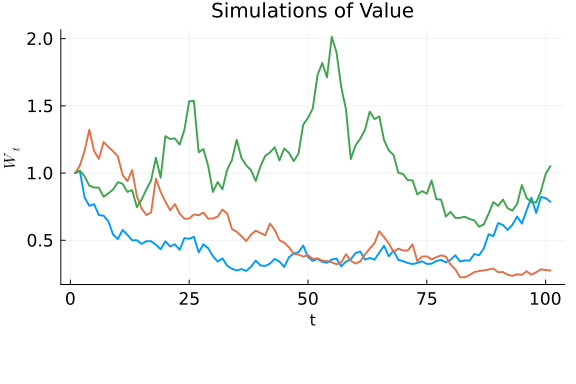

In [33]:
mu = -0.01
sigma = 0.1
R_dist = LogNormal(mu, sigma)
T = 100
W_0 = 1.0
@show mean(R_dist)
@show exp(mu + sigma^2/2)
plot(iterate_map_iid((W, R) -> W * R, R_dist,
                     W_0, T);
     ylabel = L"W_t", xlabel = "t",
     size = (600, 400), legend=nothing,
     title = "Simulations of Value")
plot!(iterate_map_iid((W, R) -> W * R, R_dist,
      W_0, T))
plot!(iterate_map_iid((W, R) -> W * R, R_dist,
      W_0, T))

## Simulating an Ensemble

-   Frequently we will want to simulate a large number of paths


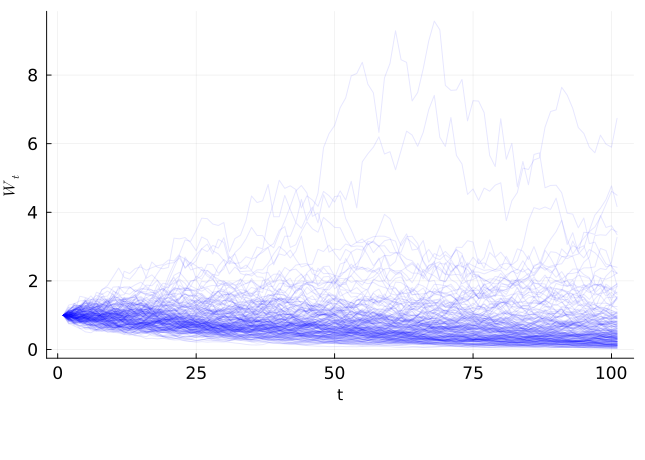

In [34]:
function iterate_map_iid_ensemble(f, dist, x0, T, num_samples)
    x = zeros(num_samples, T + 1)
    x[:, 1] .= x0
    for t in 2:(T + 1)
        # or could do a loop over samples
        x[:, t] .= f.(x[:, t - 1], rand(dist, num_samples))
    end
    return x
end
num_samples = 200
W = iterate_map_iid_ensemble((W, R) -> W * R, R_dist, W_0, T, num_samples)
plot(W'; ylabel = L"W_t", xlabel = "t", legend = nothing, alpha = 0.1,
     color=:blue, lw = 1)

## Distribution of Ensemble Values at t=10


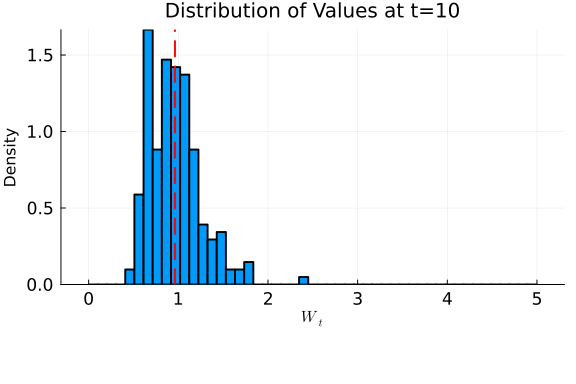

In [35]:
t = 10
bin_edges = range(0.0, 5.0, length=50)
histogram(W[:,t+1]; normalize=:pdf,
         xlabel=L"W_t", ylabel="Density",
         title="Distribution of Values at t=$(t)",
         legend=nothing, size=(600,400),
         bins=bin_edges)
vline!([mean(W[:,t+1])]; color=:red, linestyle=:dash, label="Mean")

## Distribution of Ensemble Values at t=50


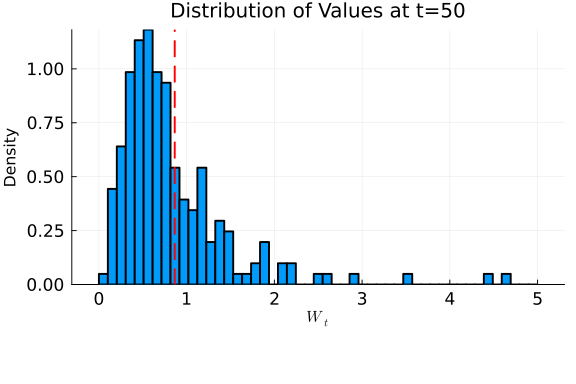

## Distribution of Ensemble Values at t=100


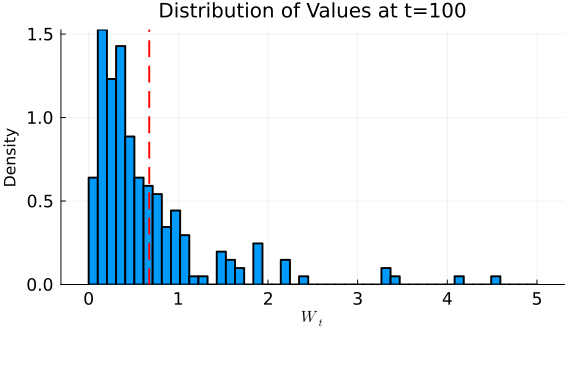

## Displaying the Distribution Dynamics


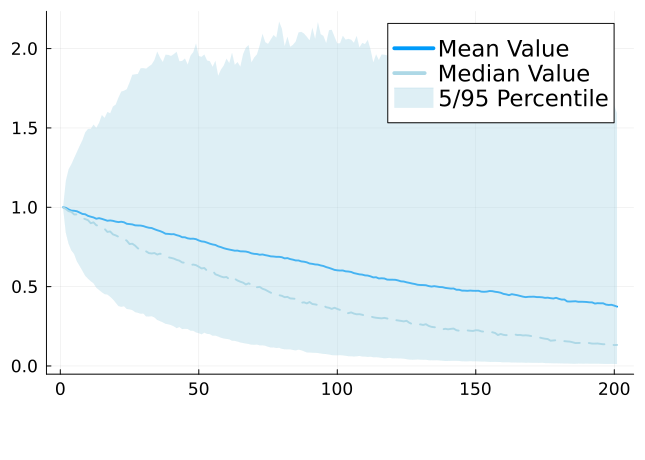

In [38]:
num_samples = 1000
T = 200
W = iterate_map_iid_ensemble((W, R) -> W * R, R_dist, W_0, T, num_samples)
q_50 = [quantile(W[:,i], 0.5) for i in 1:T+1]
q_05 = [quantile(W[:,i], 0.05) for i in 1:T+1]
q_95 = [quantile(W[:,i], 0.95) for i in 1:T+1]
mean_W = mean(W, dims=1)'
plot(mean_W; label = "Mean Value")
plot!(q_50; label = "Median Value", style = :dash, color = :lightblue)
plot!(q_05; label = "5/95 Percentile", lw=0, fillrange = q_95, fillalpha=0.4, color = :lightblue)

## Larger Returns

mean(R_dist) = 1.004008010677342


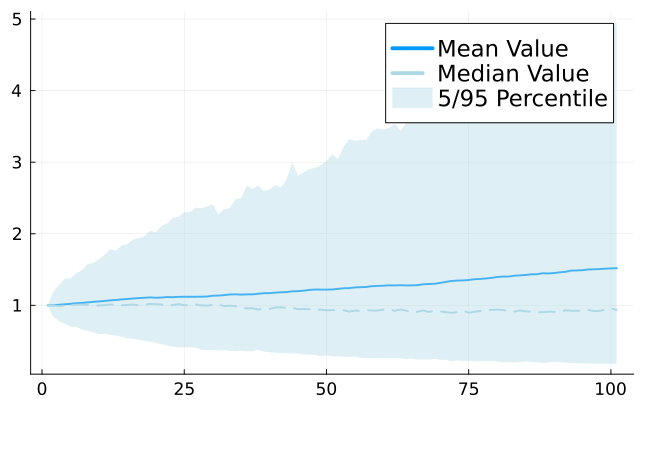

In [39]:
mu = -0.001
sigma = 0.1
R_dist = LogNormal(mu, sigma)
T = 100
W_0 = 1.0
@show mean(R_dist)
num_samples = 1000
W = iterate_map_iid_ensemble((W, R) -> W * R, R_dist, W_0, T, num_samples)
q_50 = [quantile(W[:,i], 0.5) for i in 1:T+1]
q_05 = [quantile(W[:,i], 0.05) for i in 1:T+1]
q_95 = [quantile(W[:,i], 0.95) for i in 1:T+1]
mean_W = mean(W, dims=1)'
plot(mean_W; label = "Mean Value")
plot!(q_50; label = "Median Value", style = :dash, color = :lightblue)
plot!(q_05; label = "5/95 Percentile", lw=0, fillrange = q_95, fillalpha=0.4, color = :lightblue)

## Distribution of Ensemble Values at t=10


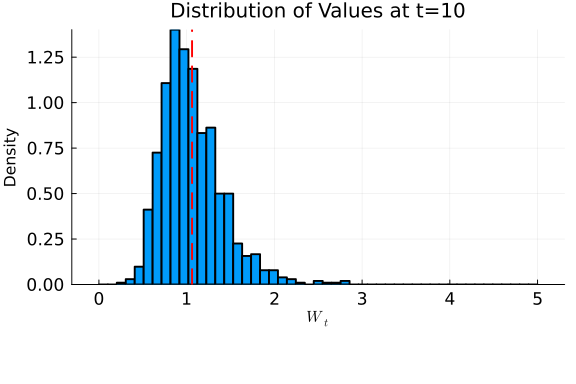

In [40]:
t = 10
bin_edges = range(0.0, 5.0, length=50)
histogram(W[:,t+1]; normalize=:pdf,
         xlabel=L"W_t", ylabel="Density",
         title="Distribution of Values at t=$(t)",
         legend=nothing, size=(600,400),
         bins=bin_edges)
vline!([mean_W[t+1]]; color=:red, linestyle=:dash, label="Mean")

## Distribution of Ensemble Values at t=50


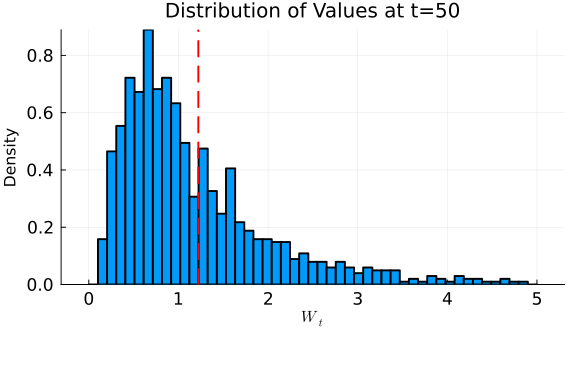

## Distribution of Ensemble Values at t=100


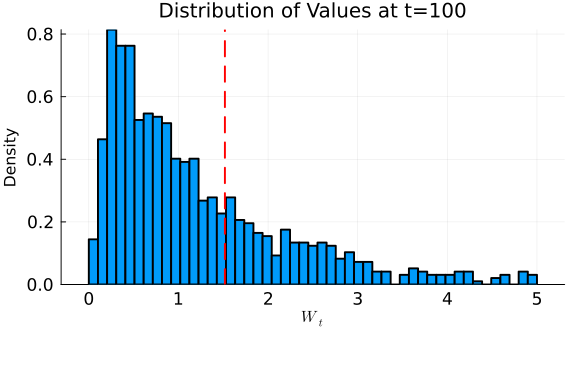

## Divergence and Tails of Distributions

-   These examples show that for multiplicative processes the
    distributions will often fan out, and potentially diverge
-   This is a common feature of many economic and financial time series
-   In particular, theory will show that for Kesten Processes, the tails
    of the distribution will be heavy even if it converges to a
    stationary distribution
    -   i.e. the probability of large deviations from the mean will be
        higher than for a normal distribution
-   These will have what we call Power Law tails in the next section